# Hosting Capacity is a Complex Process

According to <https://www.epri.com/research/products/000000003002019750>, Hosting capacity, a crucial aspect of understanding the impacts of Distributed Energy Resources (DER) on the distribution system, is a complex process involving data collection, analysis, and application. The process requires a robust dataset, various analytical methodologies, and its results are used for planning or informing interconnection decisions. Despite its complexity and the challenges in data handling and establishing an analytical framework, it's essential to ensure the hosting capacity process meets the end-use application effectively and efficiently.

## Example of Hosting Capacity for Centralized New Generation considering Overvoltage metric

In this example, we're exploring the complexity of calculating hosting capacity. We'll specifically compute the new generation hosting capacity for a specific location in the circuit, using only the overvoltage metric.

The decisions made include:

1. Allocation type: We've chosen centralized, which calculates the hosting capacity for a single location. Alternatively, we could select a distributed type, where multiple devices are connected simultaneously.

2. Device type: We've selected generation. Other options could be load or storage.

3. Metric: We're using Overvoltage. Other metrics could include thermal for generation, voltage deviation, reverse power flow, and more.

This example uses Python to control OpenDSS.
1. OpenDSS: <https://www.epri.com/pages/sa/opendss>
2. py-dss-interface: <https://pypi.org/project/py-dss-interface/>


In [1]:
# -*- coding: utf-8 -*-
# @Author  : Paulo Radatz
# @Email   : pradatz@epri.com

In [2]:
import py_dss_interface
import os
import pathlib
import numpy as np
from py_dss_tools import dss_tools

In [3]:
from FeederCondition import FeederCondition
from HCSteps import HCSteps
from HCSeetings import HCSettings

### Feeder Model
Hosting capacity analysis requires a feeder model. You can find the feeder used in this example at <https://github.com/rkerestes/IEEE1729DynamicsTF/tree/main/HCA>

In [4]:
dss_file = r"C:\PauloRadatz\GitHub\IEEEP1729-HCA\feeders\105bus\HCABase.dss"

In [5]:
dss = py_dss_interface.DSS()
dss_tools.update_dss(dss)
dss.text(f"compile [{dss_file}]")
dss.text("edit EnergyMeter.m2 enabled=no")

''

### Bus Selection
The bus selection is indicated below. 

The decision made include:
1. The location for calculating the hosting capacity. This decision is made during the calculation of centralized (locational) hosting capacity.

In [6]:
bus = "bus_1101"

### Load and Connected Generation Models

We set the load and connected (existing) DER models for the analysis. In this example, the load models maintain constant current at any voltage level. OpenDSS does not support a constant current model for connected generations, so they are defined as constant power. We could model these as a negative load and set them as constant current.

The decision made include:
1. We have chosen the load and connected DER model, which can encompass constant power, constant current, and constant impedance, among others.

In [7]:
FeederCondition.set_load_model(dss)
FeederCondition.set_generator_model(dss)

### Feeder Condition | Hosting Capacity Impact Factors
This example considers 4 impact factors. The first is the feeder's loading level. The second is how regulators factor into the hosting capacity analysis. The third is how the capacitor factors into the hosting capacity analysis. Lastly, how the connected generation impacts the results. Reference: <https://ieeexplore.ieee.org/document/10136862>
These impact factors are intended to modify the baseline power flow used in hosting capacity analysis.

The decisions to be made here include:

1. Load Level: This should provide a feeder load condition used in the hosting capacity analysis. The choice of load level depends on several factors. These include the utility's knowledge of load levels (especially the minimum load), the device under consideration, and whether the utility has load and potential connected DER profiles for accurate coincident load and DER estimation. Let's examine two examples:

- If the utility only knows the peak load and we need to calculate the generation hosting capacity, the utility must estimate the minimum load and the maximum output power of connected DER to consider in the hosting capacity analysis. Therefore, the analysis will consider the estimated minimum load, the estimated maximum output power of connected DER, and the maximum generation of the new device, which could underestimate the hosting capacity. However, if the same utility knows that the generator is a photovoltaic (PV), they could estimate a minimum load and the maximum DER output power (generation) around midday when the PV generates maximum power.

- If a utility has all profiles for loads and connected DERs, they will calculate the hosting capacity similar to the first utility. Instead of estimating the load level and output power of the connected DER, they will have that data. This results in the second utility having a hosting capacity result closer to the "real" hosting capacity.

- This example demonstrates that the more accurate and useful the utility's information is, the closer the hosting capacity results are to the "real" hosting capacity.

2. Voltage regulator: The voltage regulator can be considered in various ways during the hosting capacity analysis. For example, one could assume that it doesn't have time to change taps during a sudden change in generation output, thereby preventing any momentary voltage violation. Alternatively, we can assume that the generation output changes slowly, allowing the regulator enough time to prevent voltage violations. Another decision could be to assume that the voltage at the regulator bus is at its worst for the analysis. For example, when calculating hosting capacity considering overvoltage, the closer the voltage is to the top of the regulator bandwidth, the lower the hosting capacity results will be.So, if a utility does not have accurate information to select these options, they will likely choose the ones that provide the lowest hosting capacity results. Again, the more precise and useful the utility's information is, the closer the hosting capacity results are to the "real" hosting capacity.


3. Capacitor: The status of a capacitor (ON or OFF) significantly affects the hosting capacity results. Utilities need to identify which capacitors are switchable. They then determine the ON/OFF status of these capacitors using capacitor controls and understanding of new generation behavior. If the utility lacks this information, should they assume all capacitors are ON? It's a complex question.


4. Output power of a connected Distributed Energy Resource: What should be the defined level of output power? If the utility possesses all profiles and knowledge of the new device, it would be easy to determine. However, if they lack this information, they might choose full output power for the connected DER. This approach ensures they account for the worst possible condition for the system when calculating hosting capacity.

Again, this decisions show that the more accurate and useful the utility's information is, the closer the hosting capacity results are to the "real" hosting capacity.

In [8]:
hc_settings = HCSettings(load_mult=0.2, push_reg=1, capacitor=False, add_existing_ger=False, mult_existing_gen=0.7)

In [9]:
FeederCondition.set_capacitor_status(dss, capacitor=hc_settings.capacitor)
FeederCondition.set_load_level_condition(dss, load_mult=hc_settings.load_mult)

The voltage profile for the selected load level and capacitor status condition is illustrated below. Please note, this profile does not include the device for which we are calculating the hosting capacity.

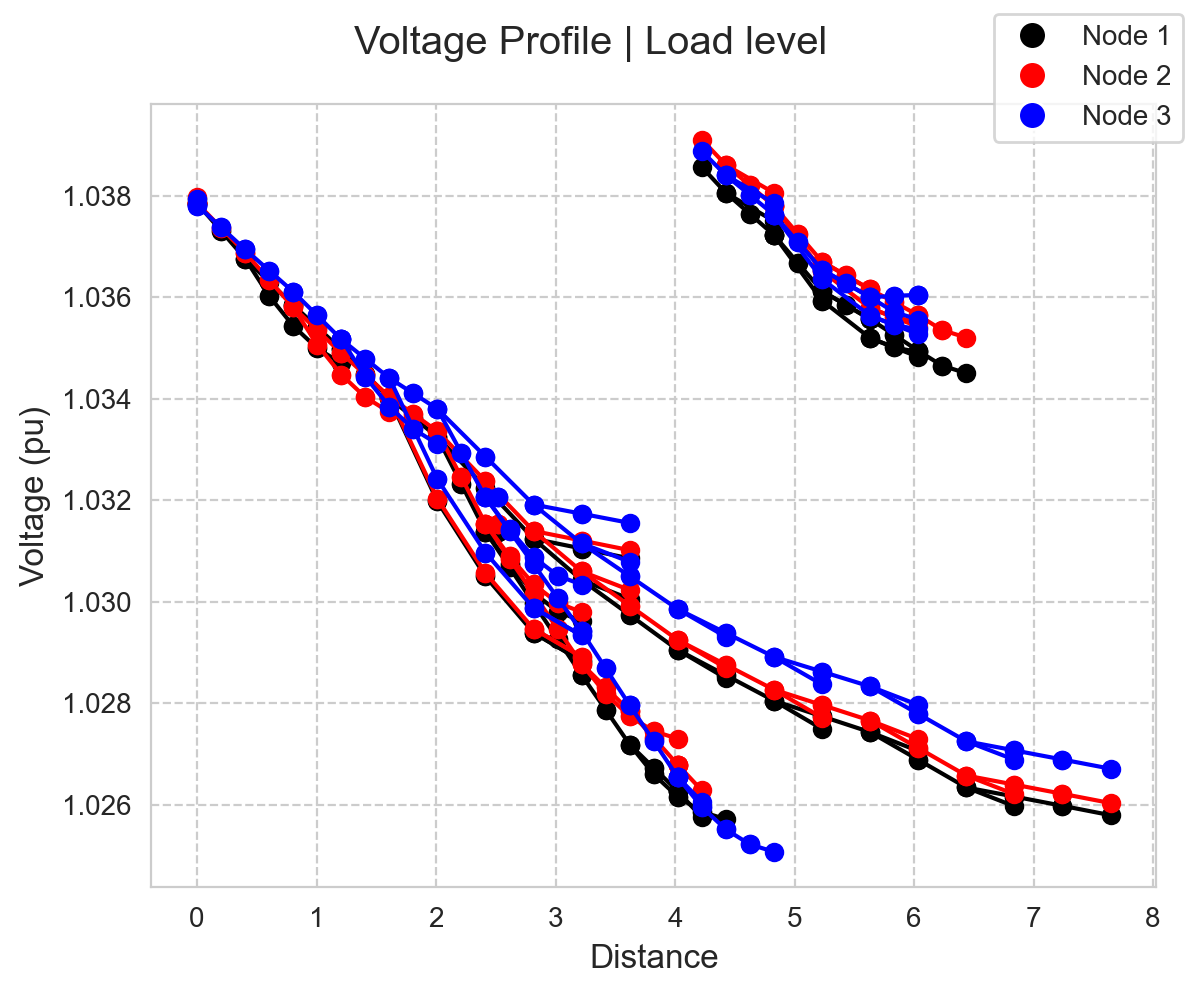

<Figure size 1000x600 with 0 Axes>

In [10]:
dss_tools.view.voltage_profile(title="Voltage Profile | Load level")

The voltage profile for the selected voltage regulator condition is illustrated below. In this case, the voltage at the regulator bus is set to the worst condition, which is the top of the bandwidth. Please note that this profile does not include the device for which we are calculating the hosting capacity.

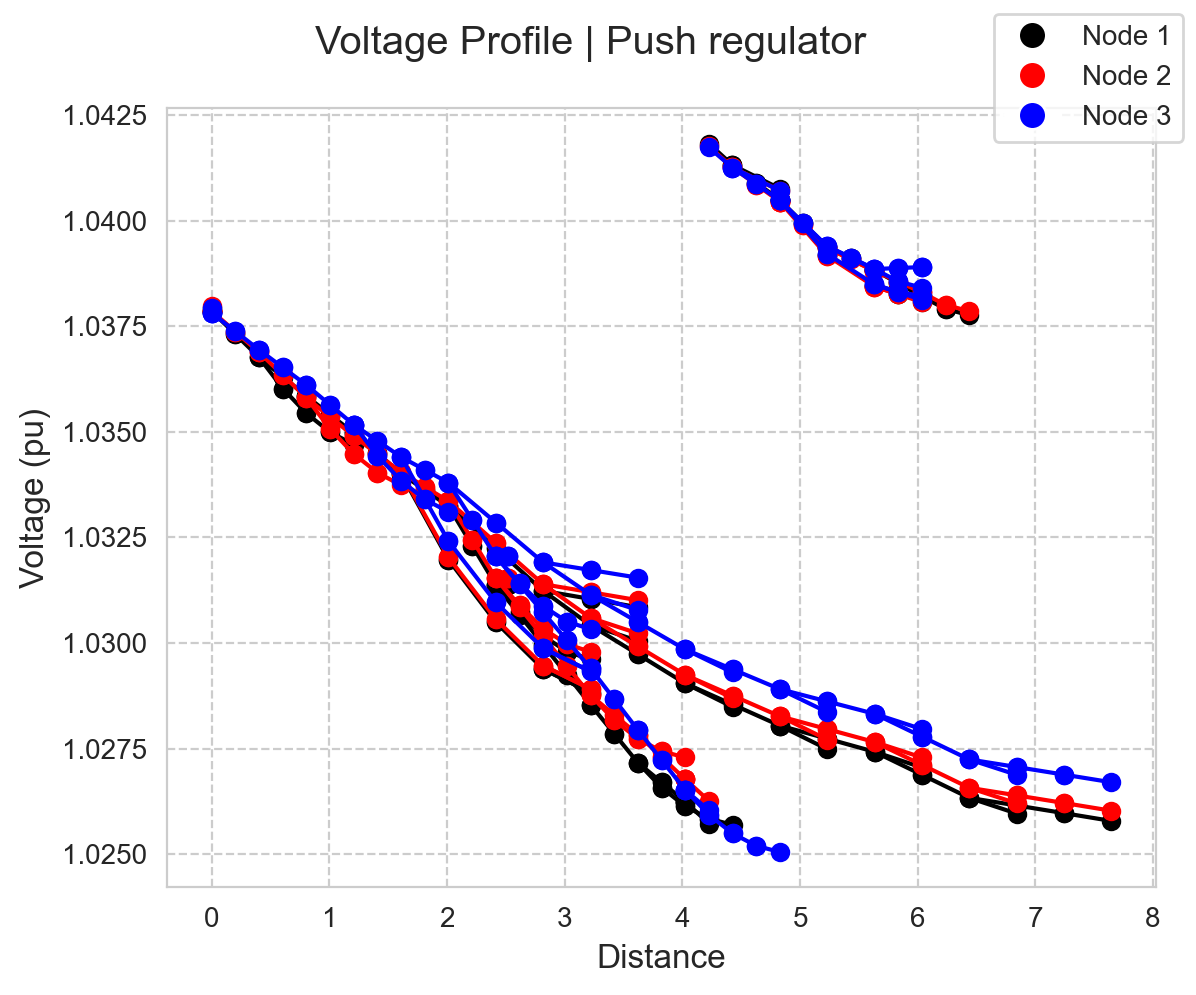

<Figure size 1000x600 with 0 Axes>

In [11]:
FeederCondition.push_regulators(dss, hc_settings.push_reg)
dss_tools.view.voltage_profile(title="Voltage Profile | Push regulator")

The voltage profile for the selected DER connection condition is shown below. Please note that this profile does not include the device for which the hosting capacity is being calculated. MY CODE DOES NOT WORK FOR THIS YET.

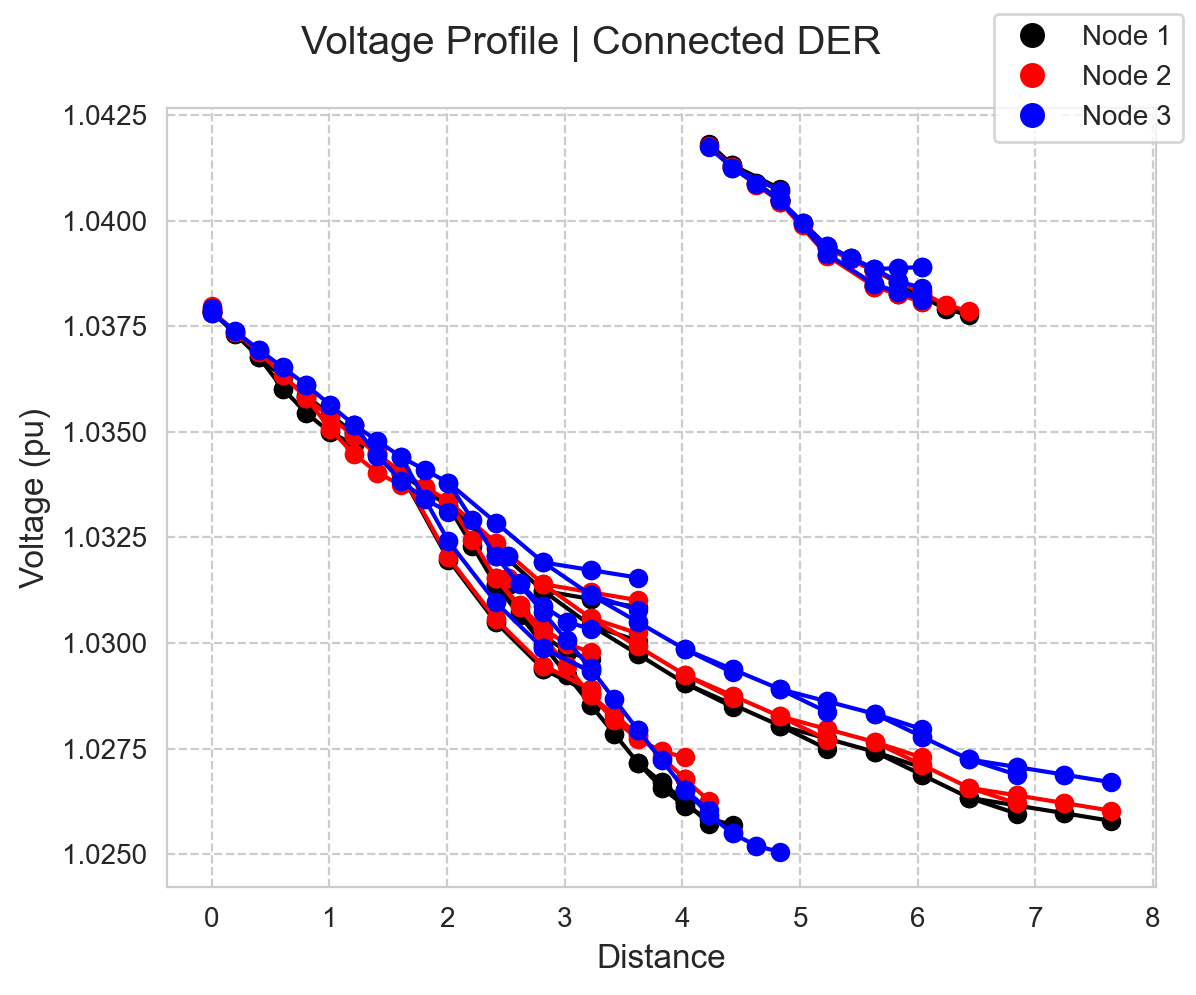

<Figure size 1000x600 with 0 Axes>

In [12]:
FeederCondition.consider_existing_gen(dss, hc_settings.add_existing_ger)
FeederCondition.set_existing_gen_mult(dss, hc_settings.mult_existing_gen)
dss_tools.view.voltage_profile(title="Voltage Profile | Connected DER")

### Adding a New Generator to the Feeder Model
We add a generator model (which could be a negative load for a constant current model) to the feeder model. In this example, the generator is 3-phase.

In [13]:
dss.circuit.set_active_bus(bus)
kv = dss.bus.kv_base * np.sqrt(3)
gen_bus = {"gen": dss.bus.name}
gen_kv = {"gen": kv}
HCSteps.add_gen(dss, gen_bus, gen_kv)

## Hosting Capacity Iterative Process

The hosting capacity iterative process incrementally increases the new generator's size. It then performs a power flow check for voltage violation. The process ends if there's a voltage violation, a voltage across the feeder exceeds the overvoltage threshold of 1.05 pu, or if the generator size reaches the maximum analyzed size, in this case, 10 kW.

Thus, the hosting capacity corresponds to the generator size from the previous iteration before the violation.

In [14]:
i = 0
while i * HCSteps.step_kw < HCSteps.max_kw:
    i = i + 1
    i_kw = i * HCSteps.step_kw
    gen_kw = {"gen": i_kw}

    # Set Penetration Level
    HCSteps.increase_gen(dss, gen_kw)

    # Perform Power flow
    HCSteps.solve_powerflow(dss)

    # Violation?
    if HCSteps.check_overvoltage_violation(dss):
        hosting_capacity_value_kw = (i - 1) * HCSteps.step_kw
        # dss.dssinterface.datapath = f"{script_path}"
        # dss.text(f"save circuit dir=dss_circuit")
        break

In [15]:
print(f"Hosting Capacity = {hosting_capacity_value_kw / 1000} MW")

Hosting Capacity = 2.49 MW


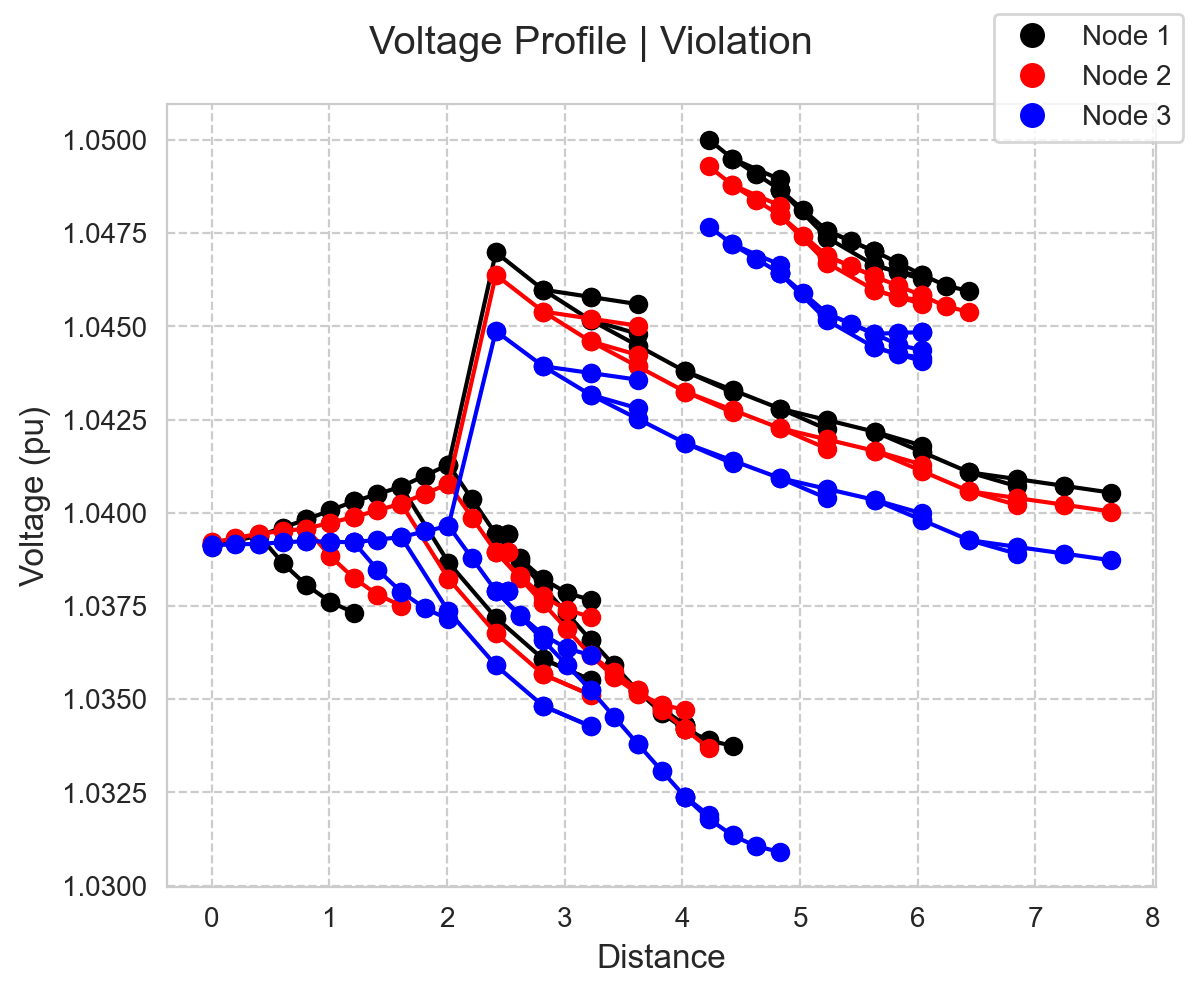

<Figure size 1000x600 with 0 Axes>

In [16]:
dss_tools.view.voltage_profile(title="Voltage Profile | Violation")

## Hosting Capacity Result

This example demonstrates that the hosting capacity result depends on various settings:

- Loading level
- Regulator and capacitor consideration in the analysis
- Existing generation

More impact factors can be considered in the analysis, such as smart inverter functionalities for the new generation.

The model itself can also significantly impact the hosting capacity results. For instance, whether the lines are modeled as positive and negative sequences, which load and generation models are considered, etc.